# Time-Series Synthesis

## Prerequisites

This tutorial assumes that you have already installed the Synthesized package. While it is not required to have read the
[Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial, it is highly recommended that you do so, as it outlines best practices when
generating and evaluating synthetic data. It is assumed that you are also familiar with the format of a time-series
dataset as laid out in [Data Formats](https://docs.synthesized.io/sdk/latest/data_formats/time_series_synthesis/).

## Introduction

In this tutorial, the `TimeSeriesSynthesizer` is introduced as a means to generate data while maintaining the temporal
correlations present in the original dataset. In particular, the focus will be on time-series data where there is a
regular time interval between measurements.
This example explains the format of a time-series dataset and how it relates to creating an instance of the `TimeSeriesSynthesizer`.
The ability to train a `TimeSeriesSynthesizer` with a custom configuration is also demonstrated.
## Financial Dataset

This tutorial will use an example dataset of one hundreds day&#8217;s worth of stock information of a subset of 25 companies in
the S&amp;P 500:


In [1]:
import pandas as pd
df = pd.read_csv("sp_500_subset.csv")
df


Name        date     open     high      low    close   volume  \
0     ALK  2013-02-08   23.995   24.435   23.940   24.335  1013314   
1     ALK  2013-02-11   24.410   24.603   24.120   24.400  1124948   
2     ALK  2013-02-12   24.405   24.560   24.270   24.430  1280160   
3     ALK  2013-02-13   24.440   24.760   24.385   24.760  1146758   
4     ALK  2013-02-14   24.665   24.680   24.150   24.355  1205950   
...   ...         ...      ...      ...      ...      ...      ...   
2495  WHR  2013-06-26  114.850  116.730  111.940  112.550  1226273   
2496  WHR  2013-06-27  113.720  116.000  112.530  115.430   898379   
2497  WHR  2013-06-28  115.310  115.740  114.060  114.360  1137362   
2498  WHR  2013-07-01  115.550  117.760  114.540  115.900   884096   
2499  WHR  2013-07-02  116.010  117.950  115.670  116.350  1150999   

                 GICS Sector  
0                Industrials  
1                Industrials  
2                Industrials  
3                Industrials  
4                Industrials  
...                      ...  
2495  Consumer Discretionary  
2496  Consumer Discretionary  
2497  Consumer Discretionary  
2498  Consumer Discretionary  
2499  Consumer Discretionary  

[2500 rows x 8 columns]

This dataset is regular and not event-based as there is a constant interval between measurements of one
business day.

*Note:* Currently the `TimeSeriesSynthesizer` requires that measurements are taken over identical time-periods for every
unique entity, i.e. measurements should start and end on the same day, and the interval should be the same for each
set of time-series data across the whole dataset.
This tutorial will demonstrate how the SDK can be used to generate data for new companies, over the same time period,
which are statistically similar to the types of companies present in the original dataset. Such a task has real-world
applicability in scenarios where:

- Original data is not available past a certain date, or at all
- Data volume is low

As described in the [Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial, it is best practice to perform EDA prior to generating
any new data, with the downstream task in mind. This ensures that the relevant metrics can be tested when evaluating the
quality of the generated data. If you have not already read the [Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial you are highly
recommended to do so.

## Synthesis

The workflow for producing time-series data is slightly different from that when producing tabular data because of a
number of preprocessing steps that occur under-the-hood. For example, rather than first performing a meta extraction and
creating the model with the resulting meta object, the meta extraction is handled by the `TimeSeriesSynthesizer`
itself. The reason for this is that a time-series dataset is formed of data from multiple entities, as outlined in
our documentation concerning [Data Formats](https://docs.synthesized.io/sdk/latest/data_formats/time_series_synthesis/), and needs to be preprocessed before meta extraction
occurs. This preprocessing ensures, amongst other things, that each unique entity has the same number of time steps in
the dataset (see the above note). Only after this preprocessing can the meta data be extracted.
In order to train the model with the desired number of time steps we need to specify `max_time_steps` in
`DeepStateConfig`, used to configure the underlying model. The `max_time_steps` argument controls
the maximum number of time steps to process from each unique entity. By default this is set to 100.

In [2]:
from synthesized.config import DeepStateConfig
config = DeepStateConfig(max_time_steps=100)


The `DeepStateConfig` instance can then be passed to the `TimeSeriesSynthesizer` upon model creation, along with the
original dataset and the time-series [column specification](https://docs.synthesized.io/sdk/latest/data_formats/time_series_synthesis/):


In [18]:
from synthesized import TimeSeriesSynthesizer

id_idx = "Name"
time_idx = "date"
event_cols=["open", "high", "low", "close", "volume"]
const_cols=["GICS Sector"]

synth = TimeSeriesSynthesizer(
    df,
    id_idx=id_idx,
    time_idx=time_idx,
    event_cols=event_cols,
    const_cols=const_cols,
    exog_cols=None,
    associations=None,
    config=config
)
synth.learn(epochs=20, steps_per_epoch=500)


Training Step 10000 of 10000 ╠████████████████████╣ 
Done.


Note that since the `TimeSeriesSynthesizer` handles the process of meta extraction `associations` are passed through as an argument upon
instantiation. For more information on `Associations` see our [documentation](features:quality:constraints/rules.ipynb).
*Note:* The preprocessing carried out by the `TimeSeriesSynthesizer` means that the original DataFrame is
not required to be passed in as an argument to the `learn()` method.
Having trained the model we are now in a position to synthesize a new sequence of time-series data, however there are
additional positional arguments that can be specified when using the `TimeSeriesSynthesizer`, compared to the
`HighDimSynthesizer`, that can generate synthetic time-series data for specific unique entities, or over specific
time-periods.

- `n`: The total number of time-steps to synthesize. This includes any time-steps used by df_time_series to prime the
generator.
- `df_exogenous`: Exogenous variables linked to the time-series. Must have the same number of rows as the value `n`.
Currently this argument must be provided for regular time-series synthesis. Note that the `TimeSeriesSynthesizer`
also treats the column specified by `time_idx` as an exogenous variable during synthesis.
- `id`: This optional argument can be used to specify the unique ID of the sequence. If provided, it must correspond to
an ID in the raw dataset used during training. If this argument is not specified then time-series data corresponding to a
new ID is generated.
- `df_const`: Constant values linked to the given `id`. This should be a DataFrame containing a single row of values,
where the columns correspond to those given in `const_cols` on instantiating the `TimeSeriesSynthesizer`. If
`id` is provided and `constant_cols` was defined in the initialization then this argument should also be specified.
- `df_time_series`: Time series measurements linked to the given `id`. Providing `df_time_series` can influence the
underlying deep generative engine to generate a particular initial state that is then used during time-series generation.
The provided DataFrame must contain the same columns specified in `event_cols`. Any number of rows &#x2264; `n` can be
provided.

For example, the trained `TimeSeriesSynthesizer` object can be used to generate data representative of a single company "HCA"
for a period of 100 business days, using the first 50 days of that company&#8217;s real data to influence the underlying
deep generative engine


In [19]:
df_hca = df.set_index(id_idx).xs("HCA").head(100).reset_index()

df_synth = synth.synthesize(
    n=100,
    id="HCA",
    df_const=df_hca[const_cols].head(1),
    df_exogenous=df_hca[[time_idx]],
    df_time_series=df_hca[event_cols].head(50)
)
df_synth


Name       date       open       high        low      close   volume  \
0   HCA 2013-02-08  36.807182  36.972729  36.453377  36.734058  2515866   
1   HCA 2013-02-11  36.496559  36.628292  36.104767  36.421009  2314997   
2   HCA 2013-02-12  37.154701  37.244823  36.657677  37.090145  4730916   
3   HCA 2013-02-13  37.142532  37.358906  36.749111  37.049618  3617784   
4   HCA 2013-02-14  36.604511  36.860725  36.275719  36.676380  3154445   
..  ...        ...        ...        ...        ...        ...      ...   
95  HCA 2013-06-26  41.218464  41.195118  40.930470  41.050163  5067078   
96  HCA 2013-06-27  42.461483  41.987938  42.218227  42.263809  5482512   
97  HCA 2013-06-28  42.680801  42.329353  42.202473  42.655663  6672621   
98  HCA 2013-07-01  43.332760  43.301067  43.171032  43.245159  3427616   
99  HCA 2013-07-02  52.780640  44.289848  52.485992  46.332485  4566910   

    GICS Sector  
0   Health Care  
1   Health Care  
2   Health Care  
3   Health Care  
4   Health Care  
..          ...  
95  Health Care  
96  Health Care  
97  Health Care  
98  Health Care  
99  Health Care  

[100 rows x 8 columns]

The `TimeSeriesAssessor` (a subclass of the [`Assessor` class](https://docs.synthesized.io/sdk/latest/features/evaluation/) capable of handling
data with a temporal component) can be used to plot the features of the original and generated time series alongside one another for a
quick comparison:


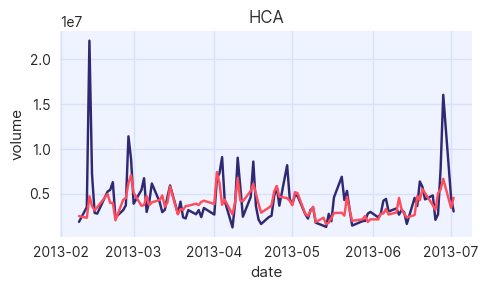

In [20]:
from synthesized.testing import TimeSeriesAssessor
assessor = TimeSeriesAssessor(synth, df_hca, df_synth)
assessor.show_series(columns=["volume"])


A more complex method of evaluating statistical quality is to compare to the auto-correlations of the synthetic and
original data. Simply put, the auto-correlation is a measure of how correlated a signal is with itself at some future
time step.


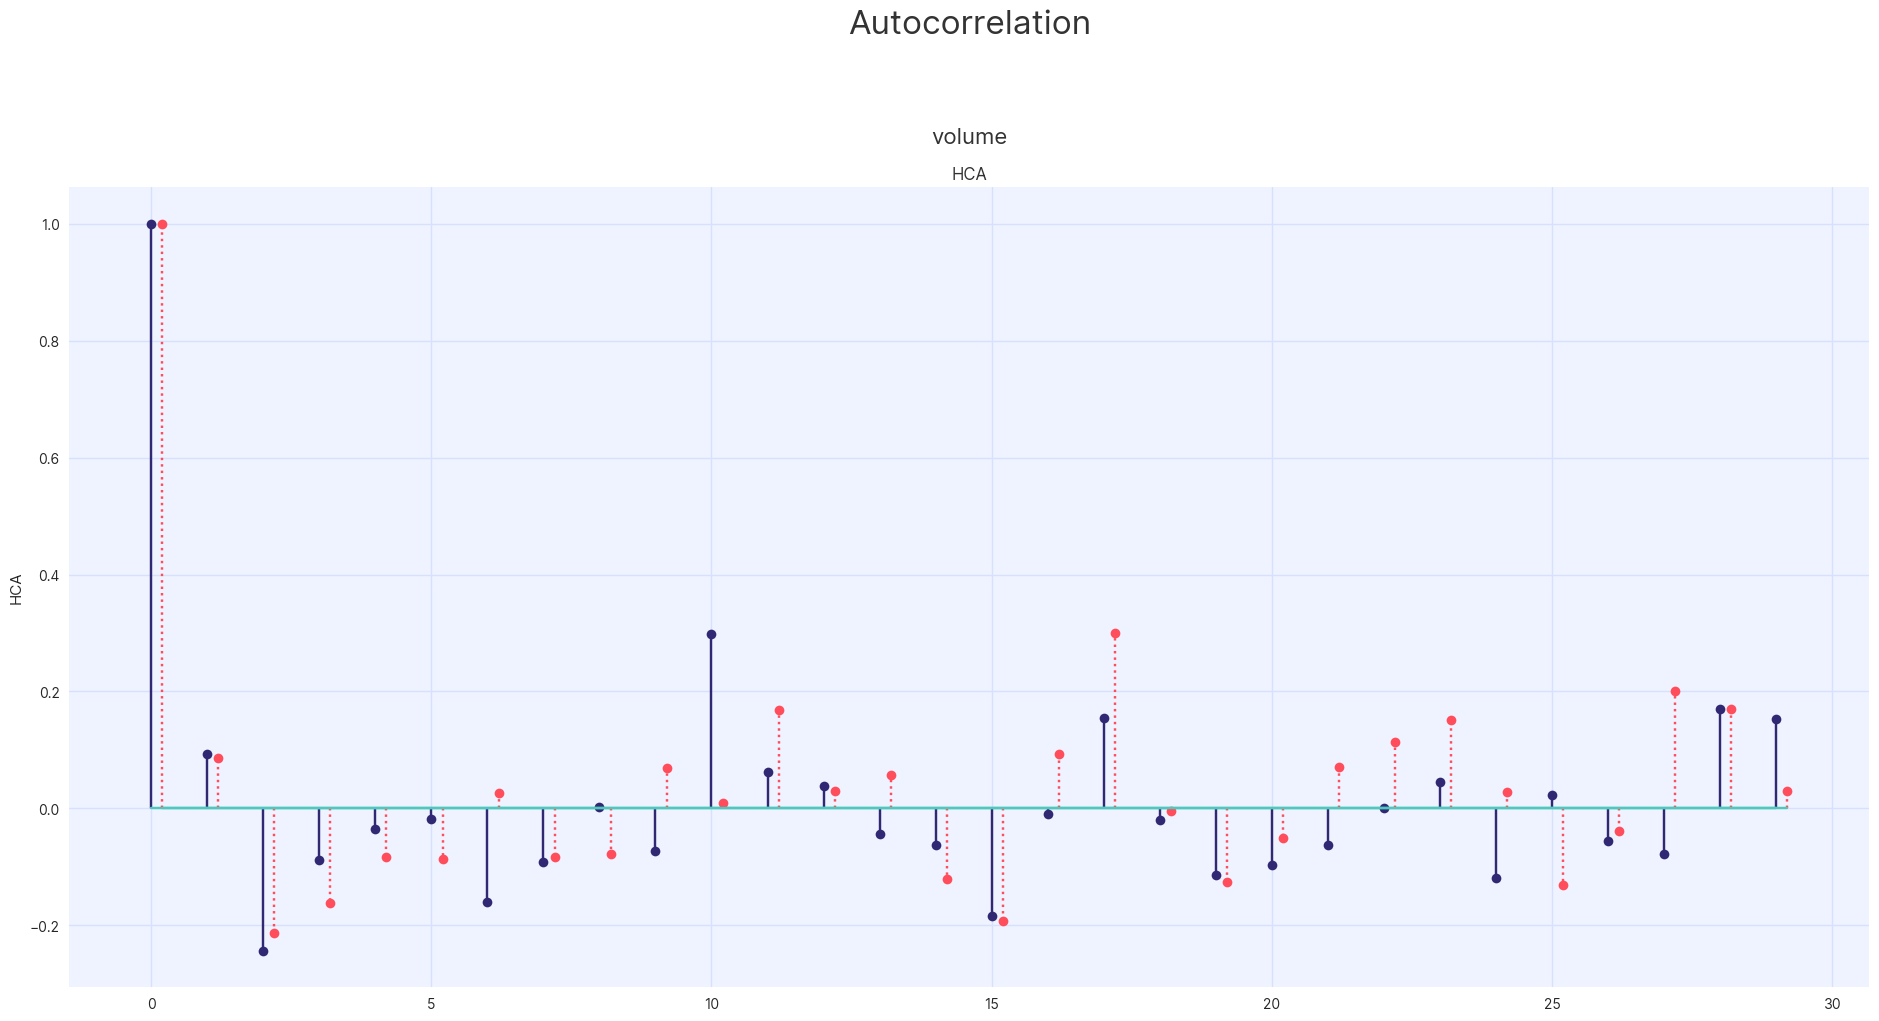

In [21]:
assessor.show_auto_associations(columns=["volume"])


Since the `TimeSeriesAssessor` subclass the `Assessor` class, it is possible to analyse the univariate and bivariate
relationships present in the data.
*Tip:* Analyse the univariate and bivariate relationships within time-series data containing a single entity. Different types
of entities can display quite different types of statistics. Calculating these metrics and correlations
on a DataFrame composed of many entities may produce an aggregated statistic that lacks any real utility.
As described in the [Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial, it is best practice to run an end-to-end synthesis using
the default parameters of the SDK. Following an initial evaluation of the data from this first iteration, fine-tuning can
be performed in order to optimise for particular metrics. For more information on fine-tuning the `TimeSeriesSynthesizer`
training please see the Hyperparameters tutorial.

## Synthesize New Entities

In order to generate new entities, the `id` argument is not specified in the call to the `synthesize` method. Instead,
the `TimeSeriesSynthesizer` will generate data corresponding to a completely new entity. Two simple functions, `generate_id()`
and `synthesize_with_generated_id()` can then be used to create data for as many new companies as desired.

In [25]:
import random
from string import ascii_uppercase

def generate_id(length):
    return "".join(random.sample(ascii_uppercase, length))

def synthesize_with_generated_id(synth, time_steps, num_companies, df_exogenous):
    df_synth = []
    for _ in range(num_companies):
        df_temp = synth.synthesize(time_steps, df_exogenous=df_exogenous)
        df_temp[id_idx] = generate_id(random.choice([3, 4]))
        df_synth.append(df_temp)

    return pd.concat(df_synth)

num_rows = synth.max_time_steps
df_synth = synthesize_with_generated_id(synth, num_rows, 25, pd.DataFrame({time_idx: pd.bdate_range(start="2013-02-08", periods=num_rows, freq="B")}))
df_synth


date       open       high        low      close   volume  \
0  2013-02-08  64.151421  63.619011  63.227467  63.159351  1595330   
1  2013-02-11  62.095371  62.308178  61.520821  61.965069  1734317   
2  2013-02-12  61.988594  61.936195  61.490334  61.885086  1393281   
3  2013-02-13  61.116726  61.022964  60.721992  60.897839  1685350   
4  2013-02-14  60.205532  59.886616  59.428959  59.879715  1726246   
..        ...        ...        ...        ...        ...      ...   
95 2013-06-21  54.234615  53.779999  53.993084  53.857979  4943178   
96 2013-06-24  53.283817  47.923233  53.084763  53.176750  4040757   
97 2013-06-25  43.648090  43.948151  44.772015  43.981956  4418298   
98 2013-06-26  53.865192  53.494259  53.704052  53.641613  4951146   
99 2013-06-27  52.425617  44.522068  52.485214  45.041206  5258041   

         GICS Sector  Name  
0          Utilities  OJDP  
1          Utilities  OJDP  
2          Utilities  OJDP  
3          Utilities  OJDP  
4          Utilities  OJDP  
..               ...   ...  
95  Consumer Staples   TLD  
96  Consumer Staples   TLD  
97  Consumer Staples   TLD  
98  Consumer Staples   TLD  
99  Consumer Staples   TLD  

[2500 rows x 8 columns]

In the above example the relatively simple `generate_id()` method creates a new company name by sampling from the 26 characters of the alphabet.
It is possible to generate more complex ID&#8217;s for different purposes using the SDK&#8217;s [Entity Annotations](https://docs.synthesized.io/sdk/latest/features/compliance/annotations).
Once again, it is instructive to perform a quick visual check of the generated data. It is a reasonably safe assumption
that companies from the same industry will perform relatively similarly, therefore a plotting function is defined that
compares original and synthetic companies from the same industry against one another:


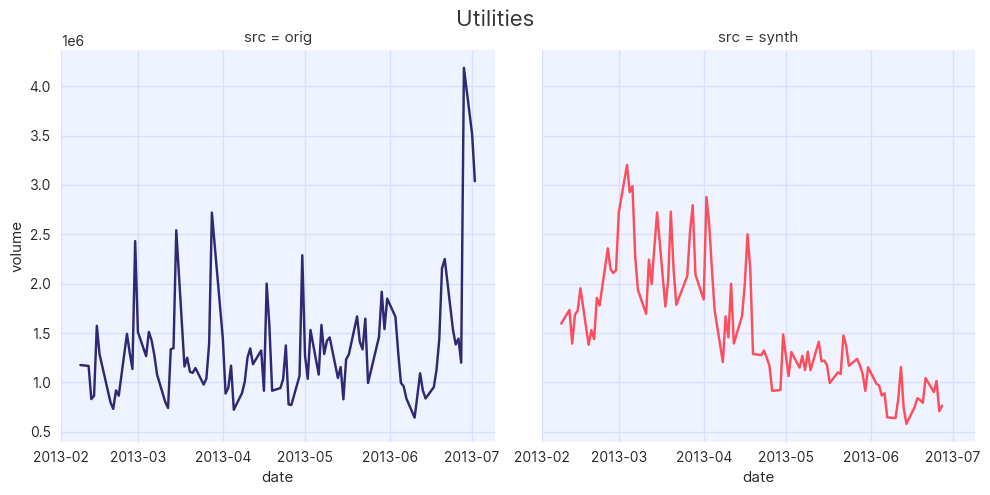

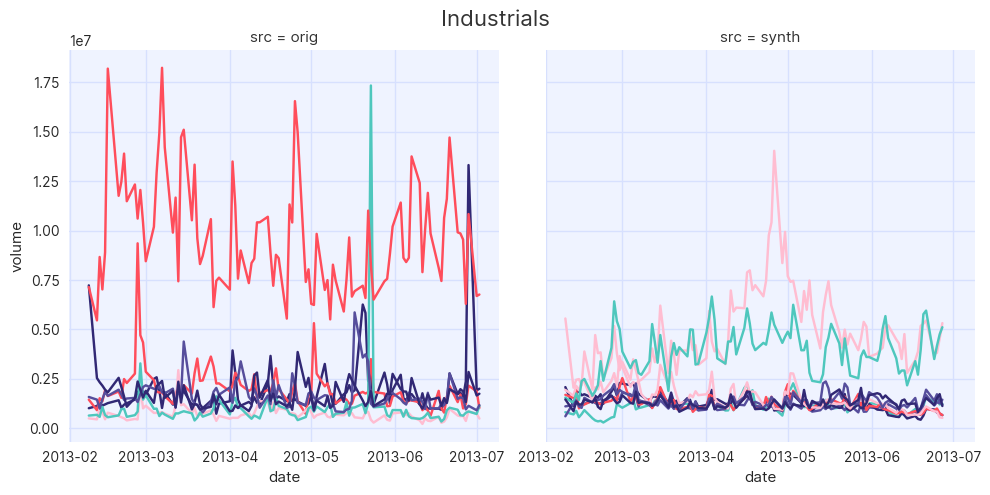

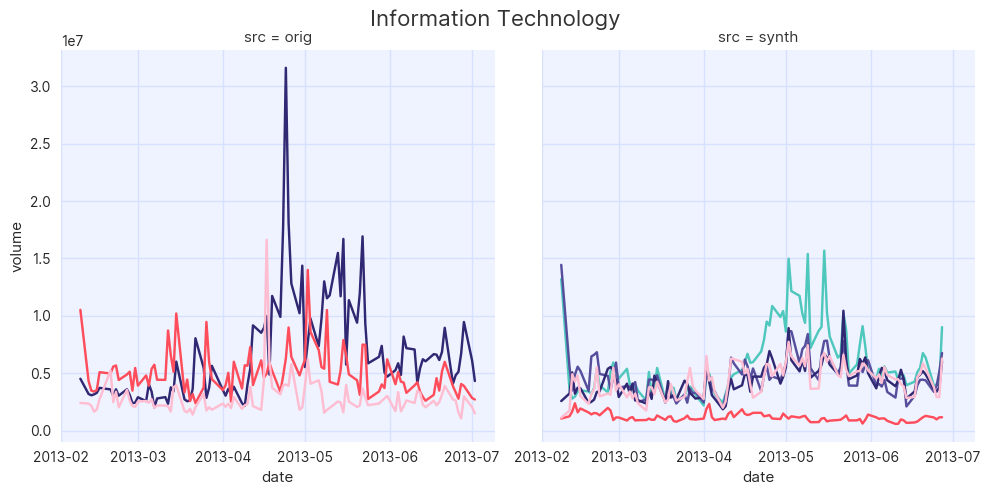

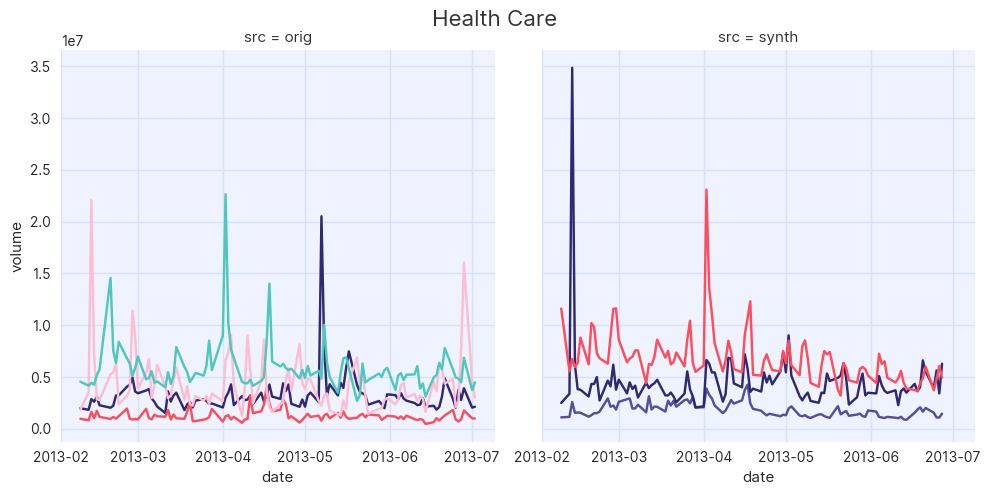

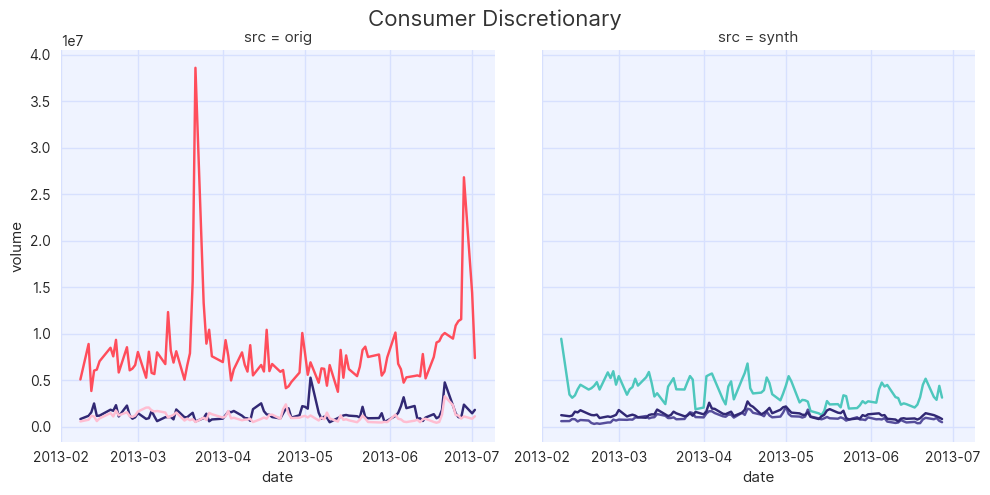

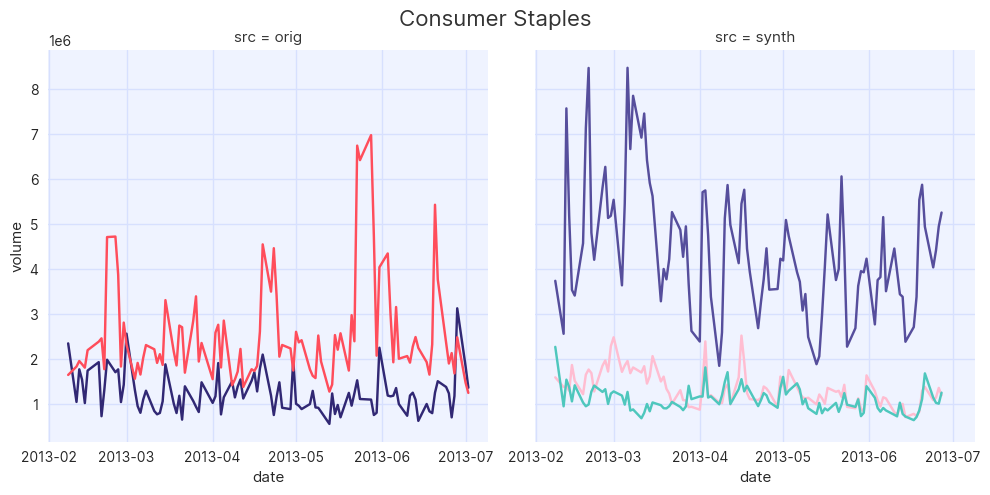

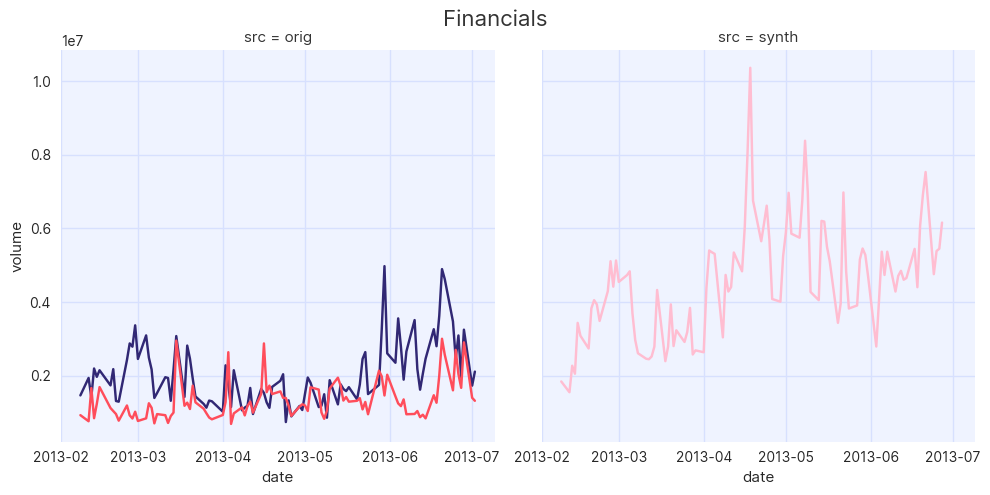

In [26]:
import seaborn as sns

def plot_by_industry(df_orig, df_synth, column, industry):

    df_orig_industry = df_orig.set_index("GICS Sector").xs(industry).reset_index()
    df_synth_industry = df_synth.set_index("GICS Sector").xs(industry).reset_index()

    df_comparison = pd.concat([df_orig_industry.assign(src="orig"), df_synth_industry.assign(src="synth")], axis=0, ignore_index=True)

    g = sns.relplot(df_comparison, x=time_idx, y=column, hue=id_idx, col="src", kind="line", legend=False)
    g.fig.suptitle(f"{industry}", fontsize=16)
    g.fig.subplots_adjust(top=0.9);

df[time_idx] = pd.to_datetime(df[time_idx])

for industry in df_synth["GICS Sector"].unique():
    plot_by_industry(df, df_synth, "volume", industry)


Quickly scanning the results, it is clear that the `TimeSeriesSynthesizer` is producing data on the same scale as the
original data for each company. The volatility (a measure of how data deviates from short term averages) of the synthetic
data for each industry also bears resemblance to the original.
In addition to the metrics described in the [Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial, it can be helpful to analyse the aggregate
statistics across time series data:


In [27]:
def aggregate(df_orig, df_synth, stat, col):

    agg_statistic = {}

    for industry in df_synth["GICS Sector"].unique():
        agg_statistic[industry] = [
            getattr(df_orig.set_index("GICS Sector").xs(industry)[col], stat)(),
            getattr(df_synth.set_index("GICS Sector").xs(industry)[col], stat)(),
        ]
    return pd.DataFrame(data=agg_statistic, index=[f"orig_{stat}", f"synth_{stat}"])


such as the mean


In [12]:
aggregate(df, df_synth, "mean", "volume")


Industrials  Real Estate  Consumer Staples   Health Care  \
orig_mean   2.669255e+06    601194.23        1882369.39  3.692133e+06   
synth_mean  2.256718e+06   3314400.27        2737286.11  3.335371e+06   

            Consumer Discretionary   Materials  Information Technology  \
orig_mean             3.449932e+06  1626211.45            4.849214e+06   
synth_mean            3.292179e+06  3699485.86            1.960988e+06   

            Financials  
orig_mean   1680161.76  
synth_mean  1149168.50

and standard deviation

In [13]:
aggregate(df, df_synth, "std", "volume")


Industrials    Real Estate  Consumer Staples   Health Care  \
orig_std   3.243124e+06  493193.509604      1.071113e+06  2.756140e+06   
synth_std  1.582531e+06  999603.049909      1.096312e+06  1.527762e+06   

           Consumer Discretionary     Materials  Information Technology  \
orig_std             4.000987e+06  7.153676e+05            3.430623e+06   
synth_std            1.310553e+06  1.160366e+06            1.207459e+06   

              Financials  
orig_std   790336.061546  
synth_std  268081.774904

It is expected that there are deviations between the values of the aggregate metric in the original and synthetic data,
both due to the relatively small numbers of companies in particular industries and due to the nature of how the `TimeSeriesSynthesizer`
generates data.
As described in the [Single Table](https://docs.synthesized.io/sdk/latest/tutorial/single_table) tutorial, the utility of synthetic data can be analysed from three
angles:

- Statistical Quality
- Predictive Utility
- Privacy

The simple analysis laid out above can be classified as an evaluation of the statistical quality of the data, but it is
by no means exhaustive. Analysing time series data is a complex subject, and should be informed by the downstream use cases
the data will be applied to.
